In [2]:
# ==============================================================================
# 第一步：环境设置
# ==============================================================================
import pandas as pd
import numpy as np
from pathlib import Path

# ==============================================================================
# 第二步：文件路径配置
# ==============================================================================
# 使用您指定的输入文件路径
input_file = Path('../../2022C/附件/附件.xlsx')

# 使用您指定的输出目录路径
output_dir = Path('../../Data')
# 确保输出目录存在，如果不存在则创建
output_dir.mkdir(parents=True, exist_ok=True)

# ==============================================================================
# 第三步：数据加载与预处理 (包含高级缺失值填充)
# ==============================================================================
# --- (3.1) 加载数据 ---
df_info = pd.read_excel(input_file, sheet_name='表单1')
df_classified = pd.read_excel(input_file, sheet_name='表单2')
df_unclassified = pd.read_excel(input_file, sheet_name='表单3')

# --- (3.2) 核心预处理 ---
# 创建合并键
df_classified['文物编号'] = df_classified['文物采样点'].str.extract(r'(\d+)').astype(int)
# 合并数据
df_merged = pd.merge(df_classified, df_info, on='文物编号', how='left')

# 确定化学成分列
chemical_columns = [col for col in df_classified.columns if col not in ['文物采样点', '文物编号']]
# 处理化学成分缺失值
df_merged[chemical_columns] = df_merged[chemical_columns].fillna(0)
df_unclassified[chemical_columns] = df_unclassified[chemical_columns].fillna(0)

# --- (3.3) 【核心修改】高级颜色缺失值填充 ---
# 定义用于分组匹配的特征列
grouping_keys = ['类型', '表面风化', '纹饰']
# 使用groupby().transform()进行高效的众数填充
# transform会返回一个与原df_merged同样索引的Series，可以直接赋值
# lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "未知") 是核心逻辑：
# 1. x.mode() 找到组内的众数
# 2. x.mode()[0] 取第一个众数（以防有并列）
# 3. if not x.mode().empty 检查该组是否存在众数（即组内是否全是NaN）
# 4. 如果没有众数，则使用'未知'作为最终的备用填充值
df_merged['颜色'] = df_merged.groupby(grouping_keys)['颜色'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "未知")
)

# 对其他可能存在的分类变量缺失值进行通用填充，以确保数据完整性
for col in ['纹饰', '类型', '表面风化']:
     if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna('未知')

# --- (3.4) 按规则筛选有效数据 ---
df_merged['成分总和'] = df_merged[chemical_columns].sum(axis=1)
df_cleaned = df_merged[(df_merged['成分总和'] >= 85) & (df_merged['成分总和'] <= 105)].copy()

df_unclassified['成分总和'] = df_unclassified[chemical_columns].sum(axis=1)
df_unclassified_cleaned = df_unclassified[(df_unclassified['成分总和'] >= 85) & (df_unclassified['成分总和'] <= 105)].copy()

print(f"数据预处理完成: 得到 {len(df_cleaned)} 条有效已分类样本 和 {len(df_unclassified_cleaned)} 条有效未分类样本。")


# ==============================================================================
# 第四步：数据量化 (按您的要求)
# ==============================================================================
# --- (4.1) 因变量 y 的量化 (目标编码) ---
type_mapping = {'铅钡': 0, '高钾': 1}
y_quantified = df_cleaned['类型'].map(type_mapping)

# --- (4.2) 自变量 X 的量化 (独热编码) ---
# 选取所有数值特征 (化学成分)
X_numeric = df_cleaned[chemical_columns]

# 【核心修改】选取原始的分类特征列进行独热编码，不再使用“_合并后”的版本
categorical_features_for_X = ['表面风化', '纹饰', '颜色']
X_categorical = df_cleaned[categorical_features_for_X]

# 执行独热编码
X_one_hot = pd.get_dummies(X_categorical, drop_first=True)

# 将数值特征和独热编码后的特征合并，构成最终的自变量矩阵 X
X_quantified = pd.concat([X_numeric, X_one_hot], axis=1)

print(f"数据量化完成: 最终特征矩阵 X 包含 {X_quantified.shape[1]} 个特征。")


# ==============================================================================
# 第五步：保存所有输出文件
# ==============================================================================
# --- (5.1) 保存清洗后的数据 ---
output_cleaned_file = output_dir / '处理后的数据.xlsx'
with pd.ExcelWriter(output_cleaned_file) as writer:
    df_cleaned.to_excel(writer, sheet_name='已分类清洗后数据', index=False)
    df_unclassified_cleaned.to_excel(writer, sheet_name='未分类清洗后数据', index=False)
print(f"1. 清洗后的数据已保存至 -> 【{output_cleaned_file}】")

# --- (5.2) 保存量化后的建模专用数据 ---
output_X_file = output_dir / 'X_quantified.csv'
output_y_file = output_dir / 'y_quantified.csv'

X_quantified.to_csv(output_X_file, index=False)
y_quantified.to_csv(output_y_file, index=False, header=['类型'])
print(f"2. 量化后的特征矩阵X已保存至 -> 【{output_X_file}】")
print(f"3. 量化后的目标变量y已保存至 -> 【{output_y_file}】")

数据预处理完成: 得到 67 条有效已分类样本 和 8 条有效未分类样本。
数据量化完成: 最终特征矩阵 X 包含 24 个特征。
1. 清洗后的数据已保存至 -> 【..\..\Data\处理后的数据.xlsx】
2. 量化后的特征矩阵X已保存至 -> 【..\..\Data\X_quantified.csv】
3. 量化后的目标变量y已保存至 -> 【..\..\Data\y_quantified.csv】


-> “数据量化流程总结”图表已保存至: 数据量化流程总结.png


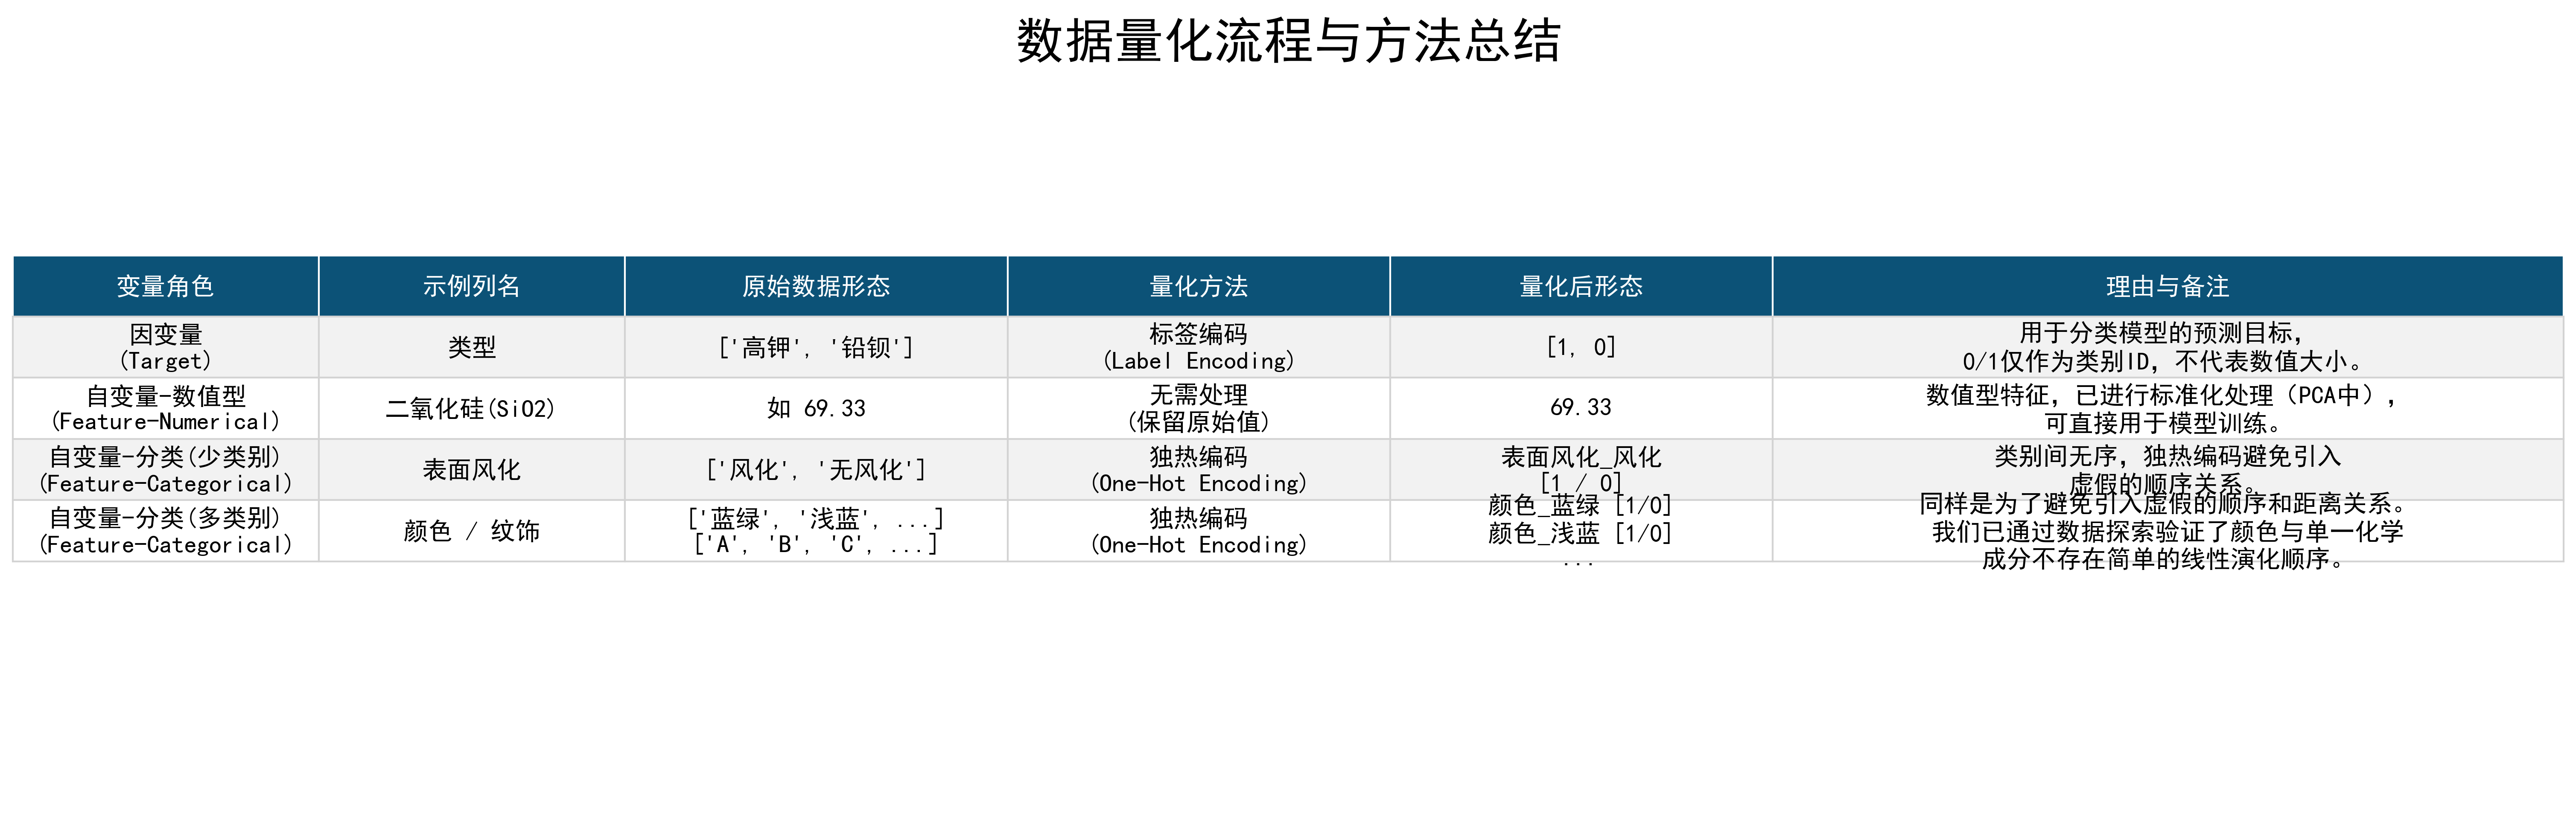

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 绘图配置 ---
# 记下了您的要求，确保中文字体、字号和风格符合标准
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# --- 表格内容定义 ---
table_data = [
    ["因变量\n(Target)", "类型", "['高钾', '铅钡']", "标签编码\n(Label Encoding)", "[1, 0]", "用于分类模型的预测目标，\n0/1仅作为类别ID，不代表数值大小。"],
    ["自变量-数值型\n(Feature-Numerical)", "二氧化硅(SiO2)", "如 69.33", "无需处理\n(保留原始值)", "69.33", "数值型特征，已进行标准化处理（PCA中），\n可直接用于模型训练。"],
    ["自变量-分类(少类别)\n(Feature-Categorical)", "表面风化", "['风化', '无风化']", "独热编码\n(One-Hot Encoding)", "表面风化_风化\n[1 / 0]", "类别间无序，独热编码避免引入\n虚假的顺序关系。"],
    ["自变量-分类(多类别)\n(Feature-Categorical)", "颜色 / 纹饰", "['蓝绿', '浅蓝', ...]\n['A', 'B', 'C', ...]", "独热编码\n(One-Hot Encoding)", "颜色_蓝绿 [1/0]\n颜色_浅蓝 [1/0]\n...", "同样是为了避免引入虚假的顺序和距离关系。\n我们已通过数据探索验证了颜色与单一化学\n成分不存在简单的线性演化顺序。"]
]

columns = ['变量角色', '示例列名', '原始数据形态', '量化方法', '量化后形态', '理由与备注']
df_table = pd.DataFrame(table_data, columns=columns)

# --- 核心绘图步骤 ---
fig, ax = plt.subplots(figsize=(20, 7)) # 调整画布大小以适应表格
ax.axis('off') # 隐藏坐标轴

# 创建表格
table = ax.table(
    cellText=df_table.values,
    colLabels=df_table.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.12, 0.12, 0.15, 0.15, 0.15, 0.31] # 调整列宽
)

# --- 美化表格 ---
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 2.5) # 调整表格单元格的整体大小

# 设置表头样式
for (i, j), cell in table.get_celld().items():
    if i == 0: # 这是表头行
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#0c5277') # 使用深色背景
        cell.set_edgecolor('white')
    else: # 数据行
        cell.set_facecolor('white')
        cell.set_edgecolor('lightgrey')
        # 交替行颜色
        if i % 2 != 0:
            cell.set_facecolor('#f2f2f2')

# 设置文本对齐
for i in range(len(columns)):
    for j in range(len(table_data) + 1):
        table[j, i].set_text_props(ha='center', va='center', wrap=True)

fig.suptitle('数据量化流程与方法总结', fontsize=28, weight='bold', y=0.9)

plt.tight_layout()

# 保存图表
save_file = "数据量化流程总结.png"
plt.savefig(save_file, bbox_inches='tight', pad_inches=0.1)
print(f"-> “数据量化流程总结”图表已保存至: {save_file}")
plt.show()

--- 开始处理表单1“颜色”列的缺失值 ---
发现 4 个样本“颜色”信息缺失。
已使用“类型+纹饰”分组的众数完成填充。

--- 正在生成佐证表格图片 ---
✅ 佐证表格图片已成功保存至: Analysis_Results\图_颜色填充依据.png


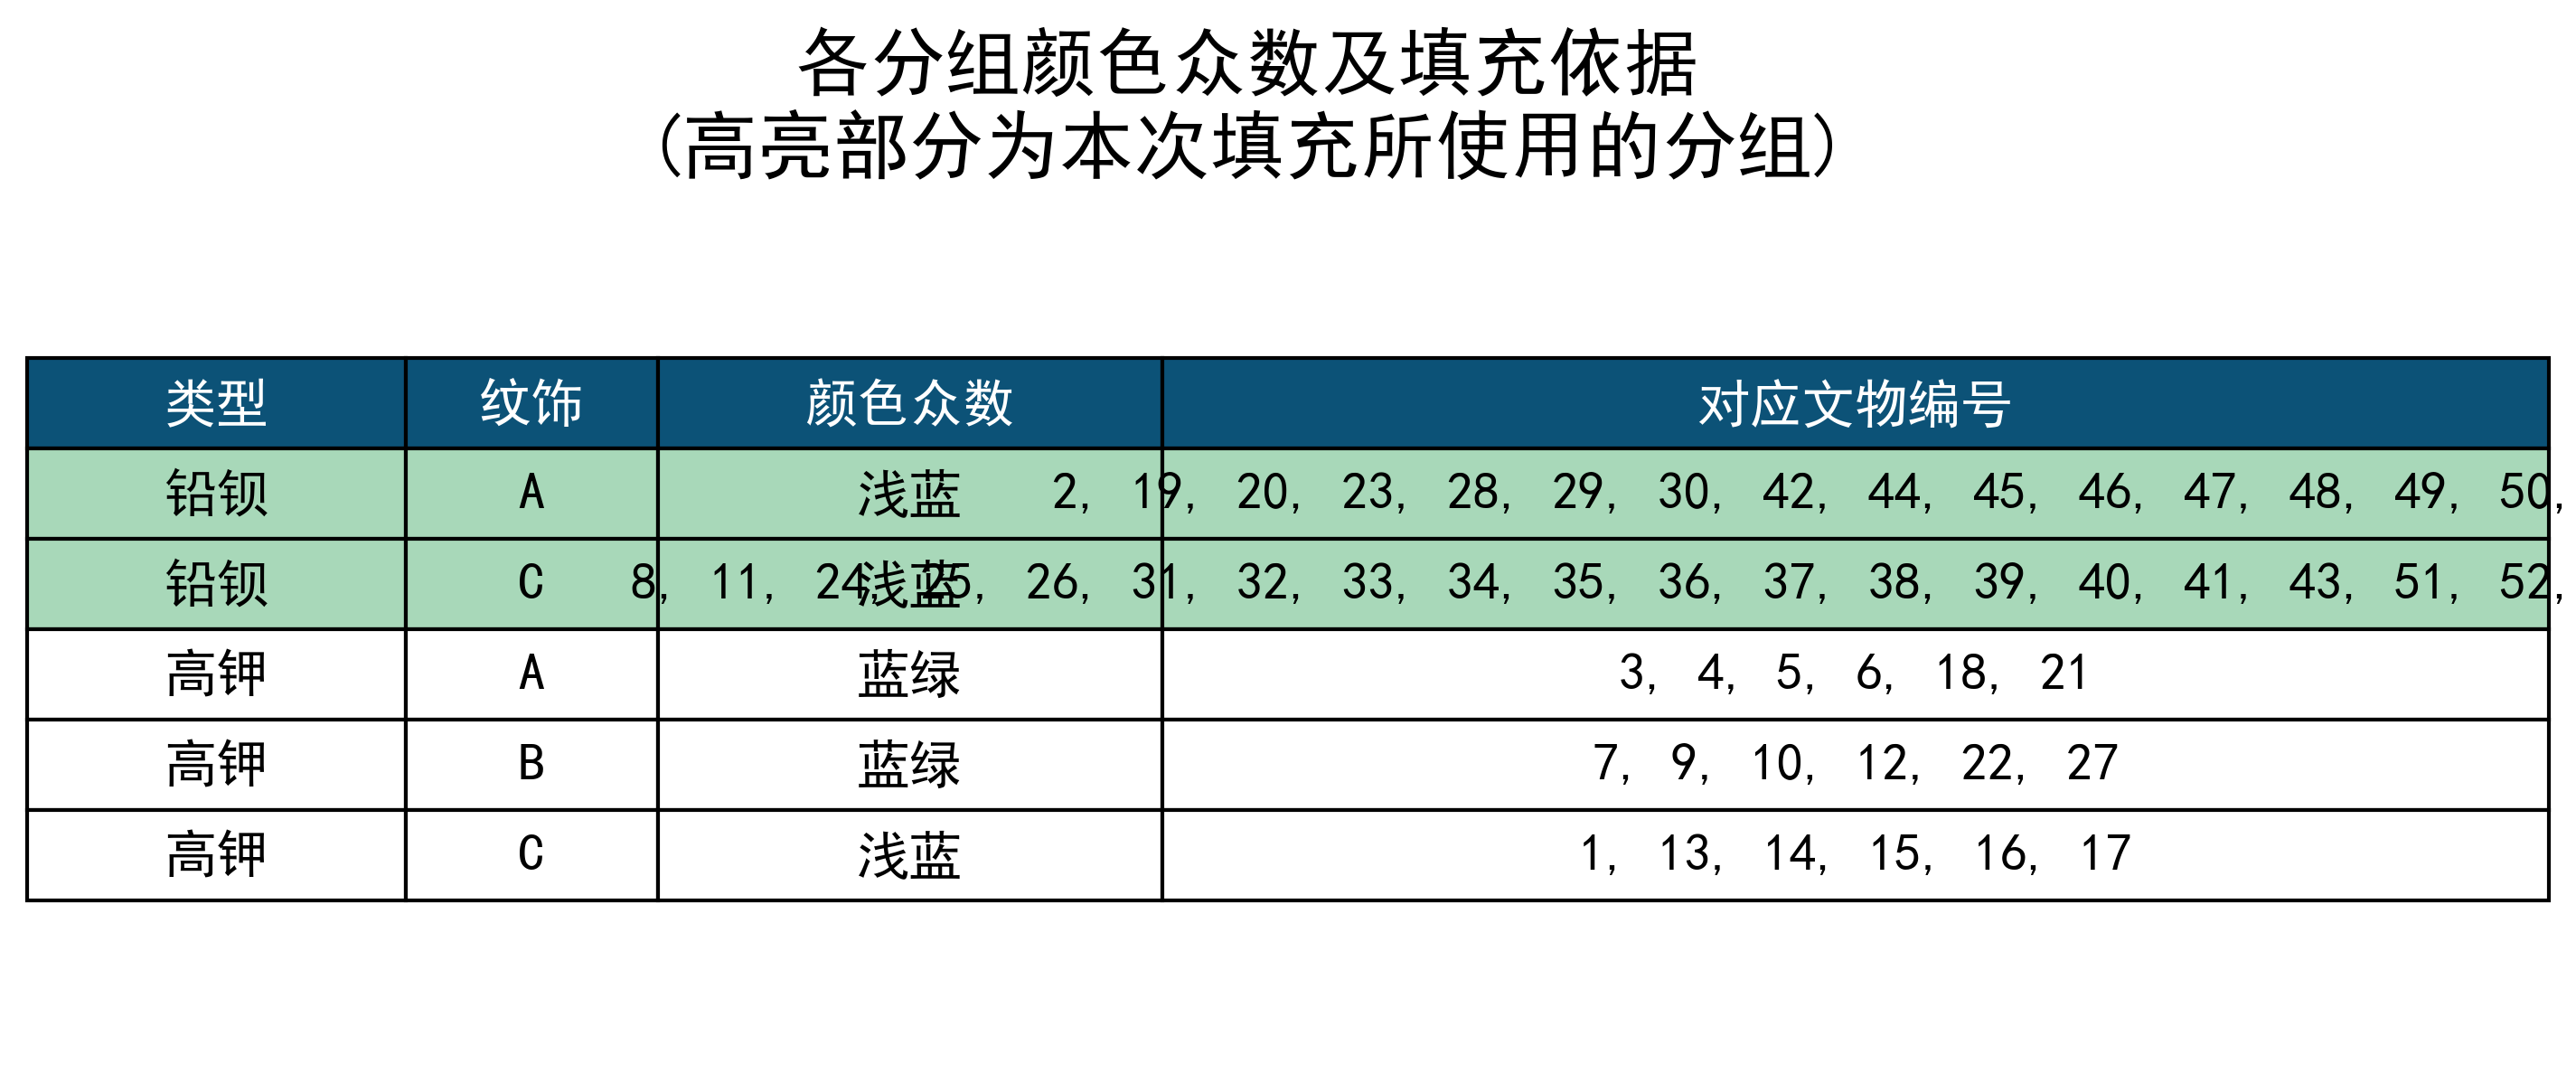

In [4]:
# ==============================================================================
# 阶段一：环境与表单1缺失值处理 (最终修正版)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- (1.1) 全局绘图与环境配置 ---
# 我遵照您的要求，设置大字号、学术风格、并确保中文正常显示
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300 # 提高保存图片的清晰度
# 我为您仔细斟酌并选择了一套观感舒适且符合学术风格的色板
COLOR_PALETTE = sns.color_palette("colorblind")
sns.set_palette(COLOR_PALETTE)

# --- (1.2) 加载数据 ---
# 【核心修正】已按您的要求，更新为新的文件路径
input_file = Path('../../2022C/附件/附件.xlsx')
output_dir = Path('Analysis_Results/')
output_dir.mkdir(parents=True, exist_ok=True)

try:
    df_info_raw = pd.read_excel(input_file, sheet_name='表单1')
    df_classified_raw = pd.read_excel(input_file, sheet_name='表单2')
    df_unclassified_raw = pd.read_excel(input_file, sheet_name='表单3')
except FileNotFoundError:
    print(f"❌ 错误：输入文件 {input_file} 未找到，请检查文件路径。")
    exit()

# 复制一份用于处理，保留原始数据
df_info = df_info_raw.copy()

# --- (1.3) 执行表单1“颜色”的条件众数填充 ---
print("--- 开始处理表单1“颜色”列的缺失值 ---")
missing_color_samples = df_info[df_info['颜色'].isnull()]
print(f"发现 {len(missing_color_samples)} 个样本“颜色”信息缺失。")

color_modes = df_info.groupby(['类型', '纹饰'])['颜色'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else '未定义').reset_index()
color_modes.rename(columns={'颜色': '颜色众数'}, inplace=True)

df_info_filled = pd.merge(df_info, color_modes, on=['类型', '纹饰'], how='left')
df_info_filled['颜色'] = df_info_filled['颜色'].fillna(df_info_filled['颜色众数'])
df_info_filled.drop(columns=['颜色众数'], inplace=True)

print("已使用“类型+纹饰”分组的众数完成填充。")

# --- (1.4) 【核心修正】使用Matplotlib生成佐证表格图片 ---
print("\n--- 正在生成佐证表格图片 ---")
# 准备用于展示的表格数据
color_modes['对应文物编号'] = color_modes.apply(
    lambda row: ', '.join(df_info[(df_info['类型'] == row['类型']) & (df_info['纹饰'] == row['纹饰'])]['文物编号'].astype(str).tolist()),
    axis=1
)
filled_ids = missing_color_samples['文物编号'].tolist()

# 创建画布和坐标轴
fig, ax = plt.subplots(figsize=(12, 4)) # 调整画布大小
ax.axis('off') # 隐藏坐标轴

# 绘制表格
table = ax.table(
    cellText=color_modes.values,
    colLabels=color_modes.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.15, 0.1, 0.2, 0.55] # 自定义列宽
)

# 美化表格
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2) # 调整单元格高度

# 遍历单元格，设置表头和高亮
for (i, j), cell in table.get_celld().items():
    # 设置表头样式
    if i == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#0c5277')
    # 数据行样式
    else:
        # 检查当前行是否是需要高亮的行
        row_data = color_modes.iloc[i-1]
        ids_in_group = [int(s.strip()) for s in row_data['对应文物编号'].split(',')]
        if any(item in filled_ids for item in ids_in_group):
            cell.set_facecolor('#a8d8b9') # 用柔和的绿色高亮

# 添加总标题
fig.suptitle(
    "各分组颜色众数及填充依据\n(高亮部分为本次填充所使用的分组)", 
    fontsize=20, weight='bold', y=1.05
)

# 保存并显示
save_path = output_dir / "图_颜色填充依据.png"
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.2)
print(f"✅ 佐证表格图片已成功保存至: {save_path}")
plt.show()


--- 开始处理表单2化学成分的缺失值 ---
表单2化学成分缺失值已填充为0。


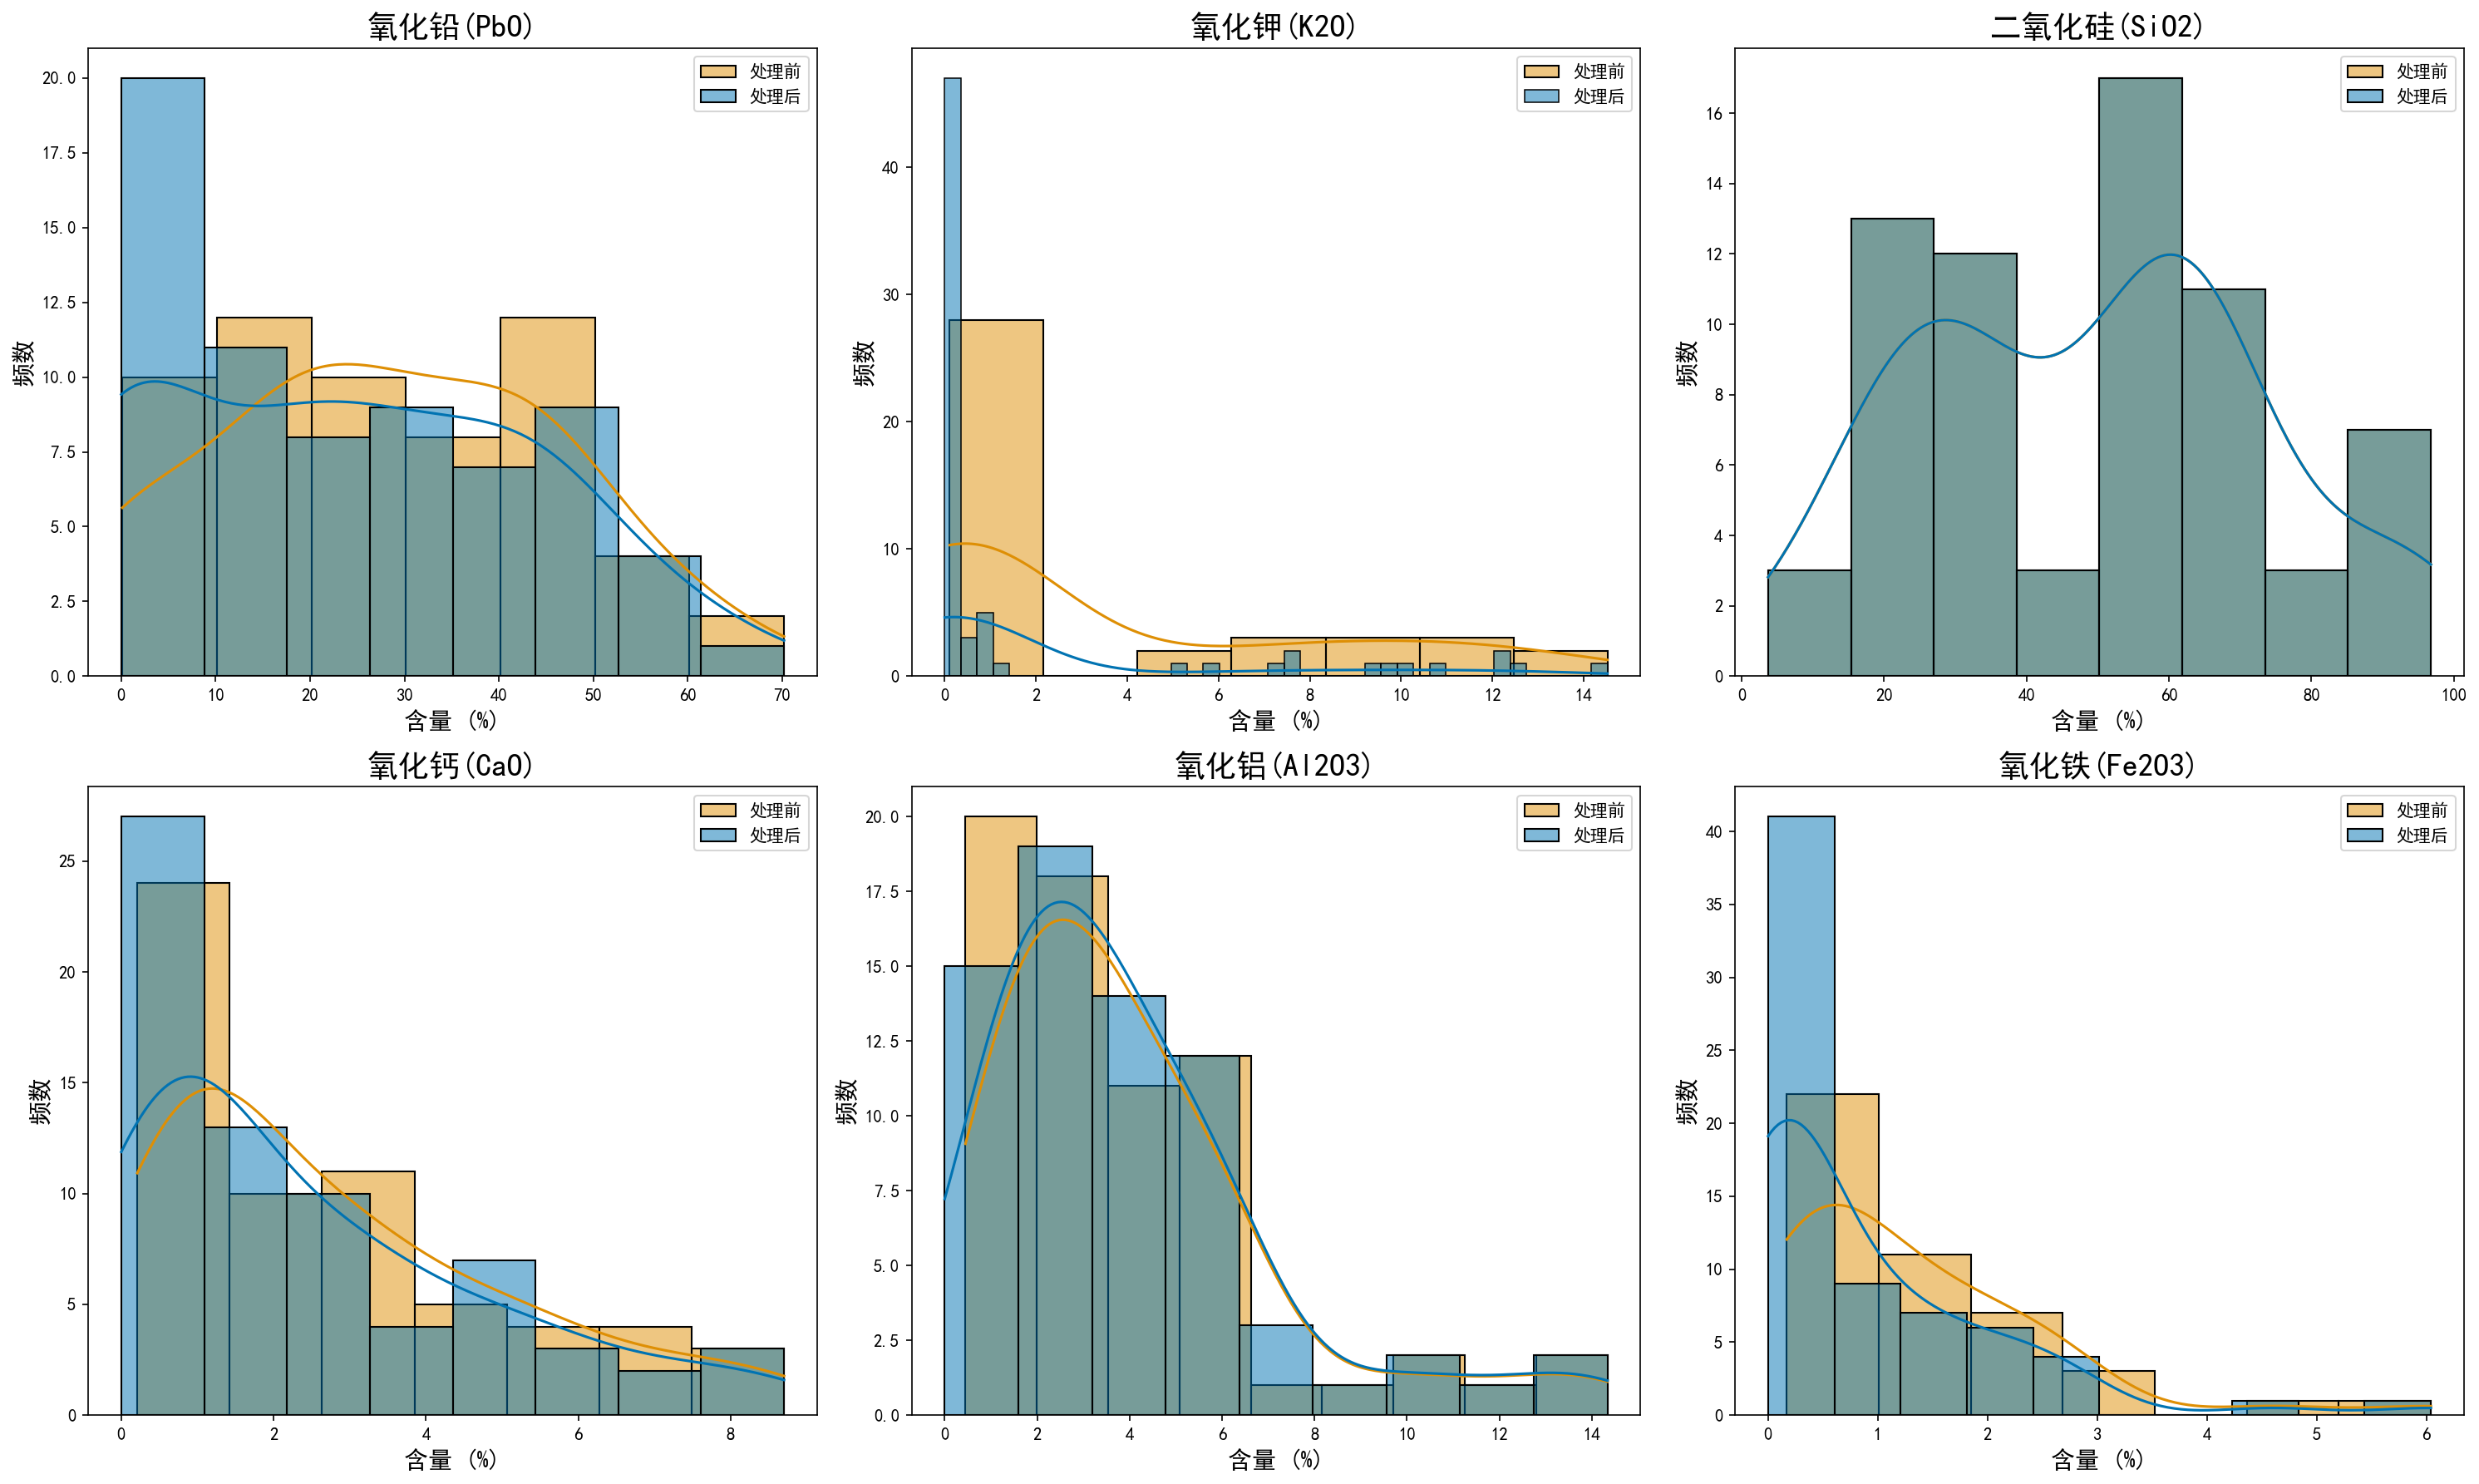


--- 开始处理表单3化学成分的缺失值 ---
表单3化学成分缺失值已填充为0。

【佐证表格】表单3填充前后对比 (前5行):

处理前:


,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,A1,无风化,78.45,NaN,NaN,6.08,1.86,7.23,2.15,2.11,NaN,NaN,1.06,0.03,NaN,0.51
1,A2,风化,37.75,NaN,NaN,7.63,NaN,2.33,NaN,NaN,34.30,NaN,14.27,NaN,NaN,NaN
2,A3,无风化,31.95,NaN,1.36,7.19,0.81,2.93,7.06,0.21,39.58,4.69,2.68,0.52,NaN,NaN
3,A4,无风化,35.47,NaN,0.79,2.89,1.05,7.07,6.45,0.96,24.28,8.31,8.45,0.28,NaN,NaN
4,A5,风化,64.29,1.2,0.37,1.64,2.34,12.75,0.81,0.94,12.23,2.16,0.19,0.21,0.49,NaN



处理后:


,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,A1,无风化,78.45,0.0,0.00,6.08,1.86,7.23,2.15,2.11,0.00,0.00,1.06,0.03,0.00,0.51
1,A2,风化,37.75,0.0,0.00,7.63,0.00,2.33,0.00,0.00,34.30,0.00,14.27,0.00,0.00,0.00
2,A3,无风化,31.95,0.0,1.36,7.19,0.81,2.93,7.06,0.21,39.58,4.69,2.68,0.52,0.00,0.00
3,A4,无风化,35.47,0.0,0.79,2.89,1.05,7.07,6.45,0.96,24.28,8.31,8.45,0.28,0.00,0.00
4,A5,风化,64.29,1.2,0.37,1.64,2.34,12.75,0.81,0.94,12.23,2.16,0.19,0.21,0.49,0.00


In [16]:
# ==============================================================================
# 阶段二：表单2与表单3缺失值处理
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# 假设 df_classified_raw 和 df_unclassified_raw 已在上一步加载

# --- (2.1) 处理表单2并可视化 ---
print("\n--- 开始处理表单2化学成分的缺失值 ---")
chemical_columns = df_classified_raw.columns[1:] # 排除第一列“文物采样点”
df_classified_filled = df_classified_raw.copy()
df_classified_filled[chemical_columns] = df_classified_filled[chemical_columns].fillna(0)
print("表单2化学成分缺失值已填充为0。")

# 可视化填充效果
# 我记下了您的要求，选择6种有代表性的成分，放入一个大图中
components_to_plot_b2 = ['氧化铅(PbO)', '氧化钾(K2O)', '二氧化硅(SiO2)', '氧化钙(CaO)', '氧化铝(Al2O3)', '氧化铁(Fe2O3)']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, chemical in enumerate(components_to_plot_b2):
    # 绘制处理前的数据分布 (排除NaN值)
    sns.histplot(df_classified_raw[chemical].dropna(), ax=axes[i], color=COLOR_PALETTE[1], kde=True, label='处理前')
    # 绘制处理后的数据分布 (包含0值)
    sns.histplot(df_classified_filled[chemical], ax=axes[i], color=COLOR_PALETTE[0], kde=True, label='处理后')
    axes[i].set_title(chemical, fontsize=18)
    axes[i].set_xlabel('含量 (%)', fontsize=14)
    axes[i].set_ylabel('频数', fontsize=14)
    axes[i].legend()

plt.tight_layout()
plt.savefig(output_dir / "图_表单2填充前后分布对比.png")
plt.show()


# --- (2.2) 处理表单3并生成对比表格 ---
print("\n--- 开始处理表单3化学成分的缺失值 ---")
df_unclassified_filled = df_unclassified_raw.copy()
df_unclassified_filled[chemical_columns] = df_unclassified_filled[chemical_columns].fillna(0)
print("表单3化学成分缺失值已填充为0。")

# 生成对比表格
print("\n【佐证表格】表单3填充前后对比 (前5行):")
print("\n处理前:")
display(df_unclassified_raw.head())
print("\n处理后:")
display(df_unclassified_filled.head())

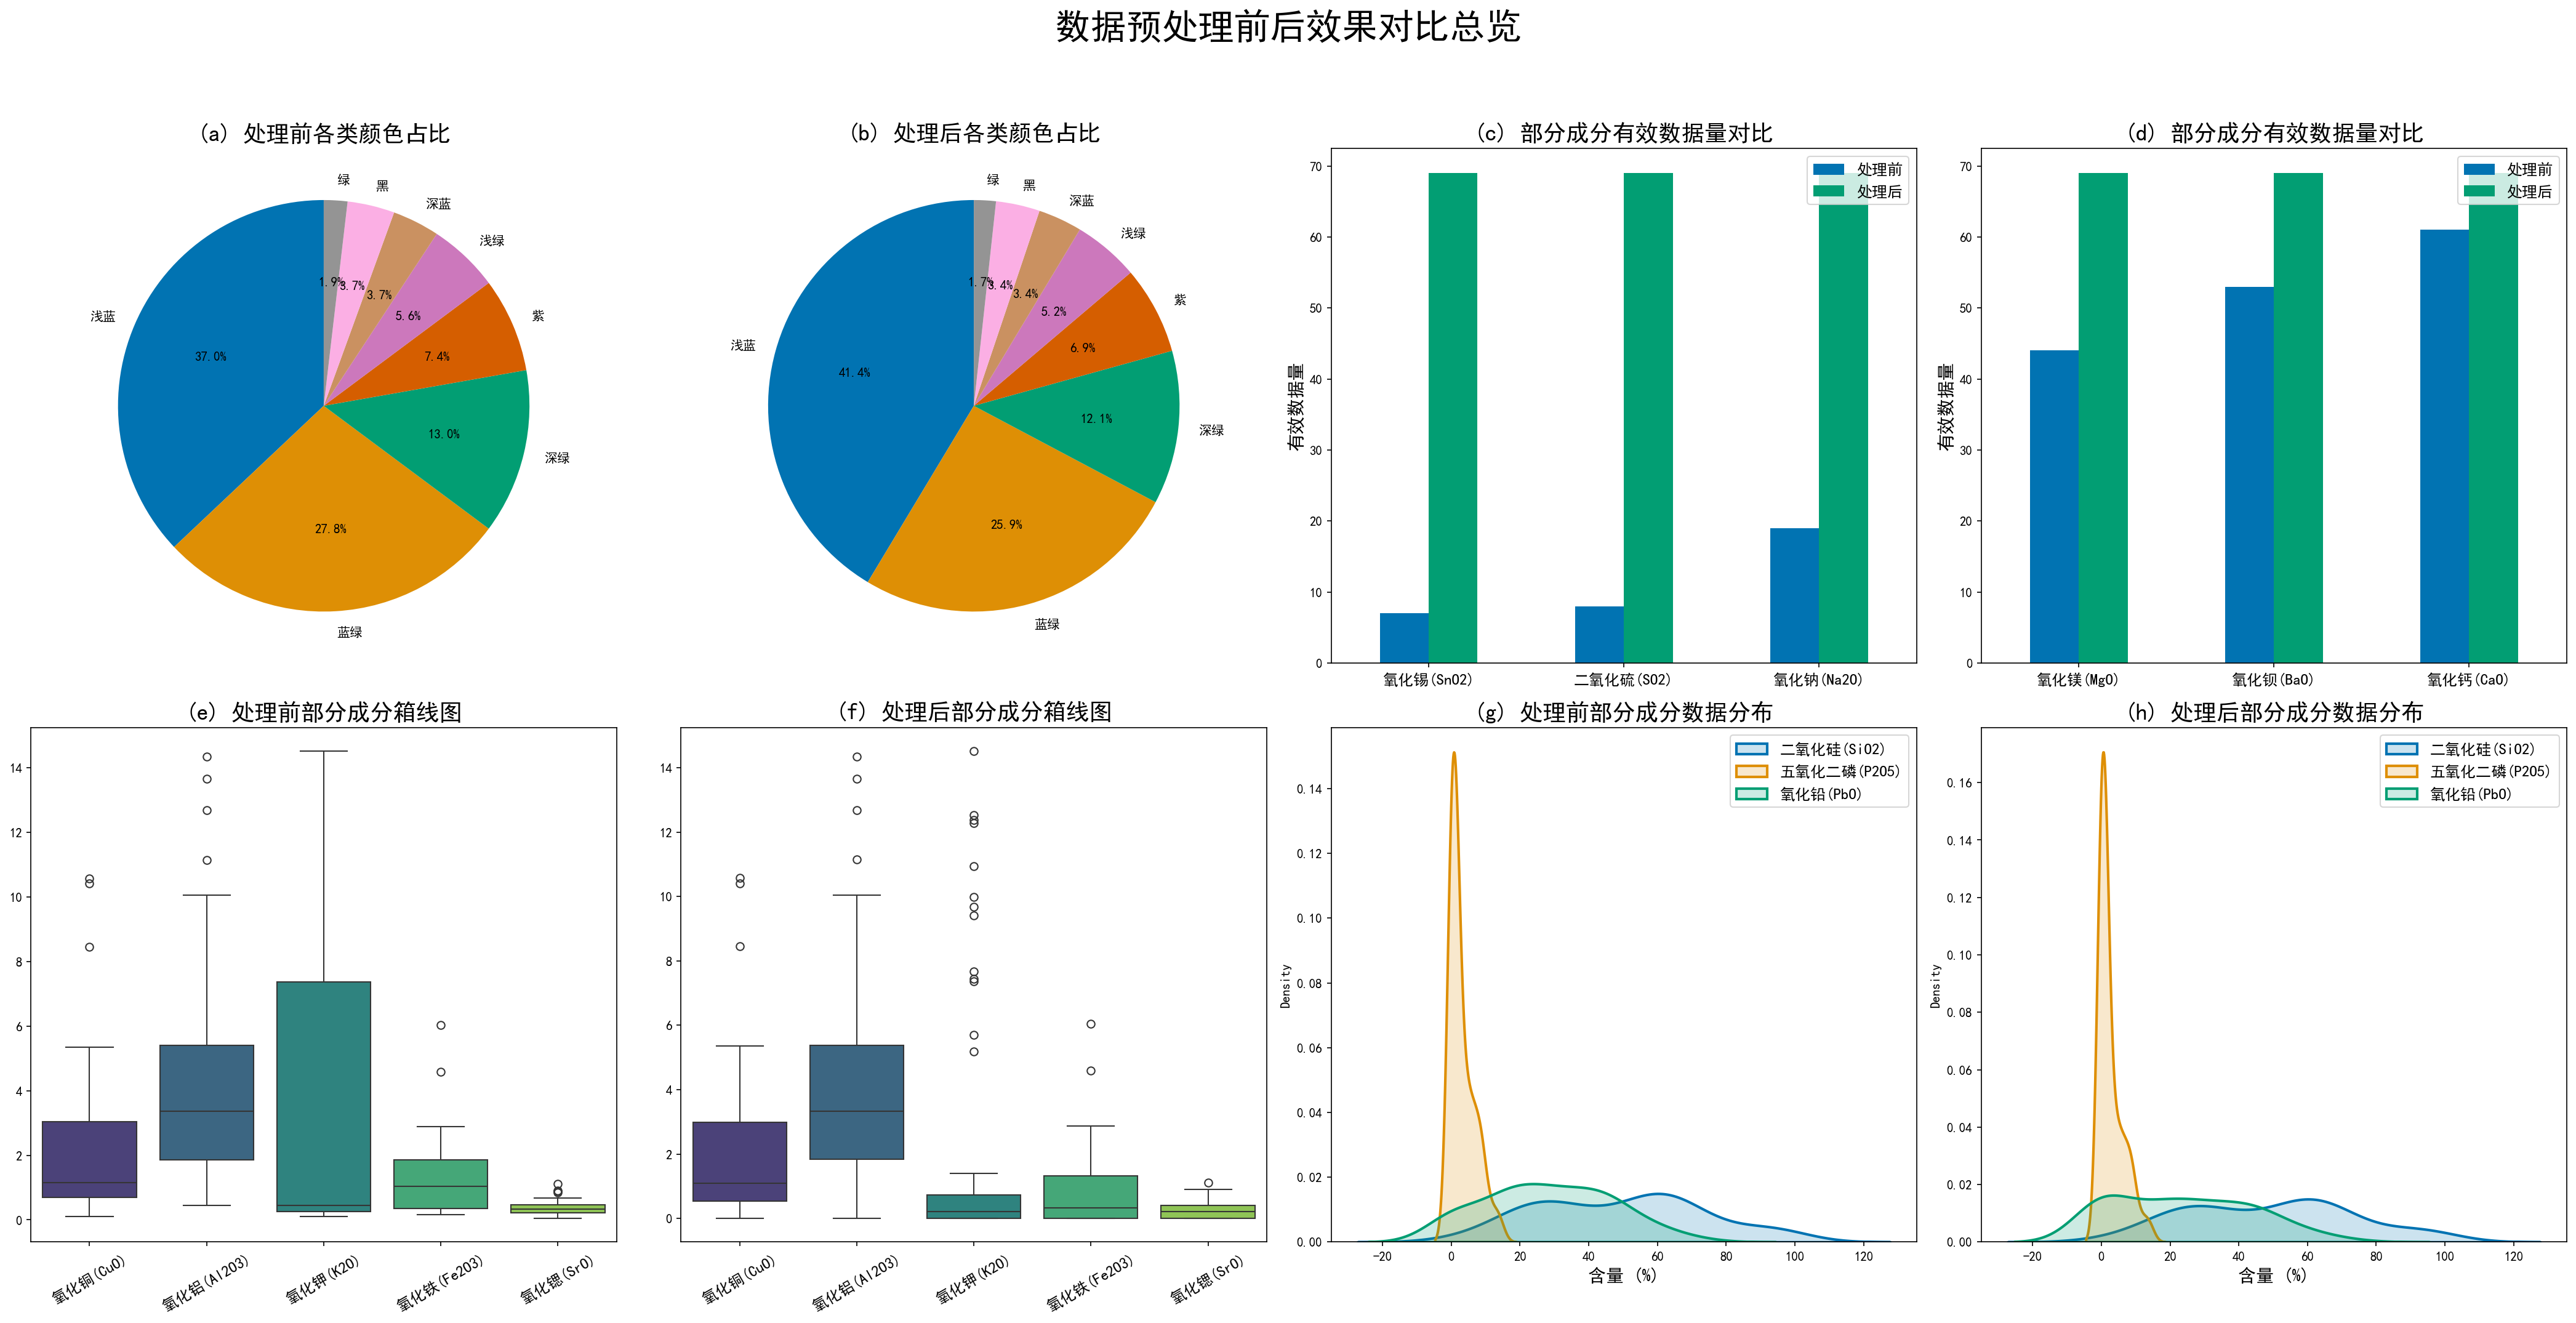

In [5]:
# ==============================================================================
# 阶段三：数据处理效果对比总览图 (g/h图修正版)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 我记下了您的要求，确保所有绘图配置（字体、色系、字号）都符合您的学术风格
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
COLOR_PALETTE = sns.color_palette("colorblind")
# 假设 df_info_raw, df_info_filled, df_classified_raw, df_classified_filled 已在之前的代码块中成功生成
output_dir = Path('Analysis_Results/')
output_dir.mkdir(parents=True, exist_ok=True)


# --- (3.1) 创建2x4子图网格 ---
fig, axes = plt.subplots(2, 4, figsize=(28, 14))

# --- (a) (b) (c) (d) (e) (f) 部分的代码与之前完全一致，这里省略以便聚焦修改 ---
# 您只需关注下面 (g) 和 (h) 部分的修正即可

# --- (a) 处理前颜色占比扇形图 ---
ax_a = axes[0, 0]
color_counts_before = df_info_raw['颜色'].value_counts()
ax_a.pie(color_counts_before, labels=color_counts_before.index, autopct='%1.1f%%', startangle=90, colors=COLOR_PALETTE)
ax_a.set_title('(a) 处理前各类颜色占比', fontsize=18)

# --- (b) 处理后颜色占比扇形图 ---
ax_b = axes[0, 1]
color_counts_after = df_info_filled['颜色'].value_counts()
ax_b.pie(color_counts_after, labels=color_counts_after.index, autopct='%1.1f%%', startangle=90, colors=COLOR_PALETTE)
ax_b.set_title('(b) 处理后各类颜色占比', fontsize=18)

# --- (c) & (d) 有效数据量前后对比条形图 ---
def plot_valid_data_comparison(ax, components, title):
    before_counts = df_classified_raw[components].notna().sum()
    after_counts = df_classified_filled[components].notna().sum()
    df_plot = pd.DataFrame({'处理前': before_counts, '处理后': after_counts})
    df_plot.plot(kind='bar', ax=ax, color=[COLOR_PALETTE[0], COLOR_PALETTE[2]])
    ax.set_title(title, fontsize=18)
    ax.set_ylabel('有效数据量', fontsize=14)
    ax.tick_params(axis='x', rotation=0, labelsize=12)
    ax.legend(fontsize=12)

plot_valid_data_comparison(axes[0, 2], ['氧化锡(SnO2)', '二氧化硫(SO2)', '氧化钠(Na2O)'], '(c) 部分成分有效数据量对比')
plot_valid_data_comparison(axes[0, 3], ['氧化镁(MgO)', '氧化钡(BaO)', '氧化钙(CaO)'], '(d) 部分成分有效数据量对比')

# --- (e) & (f) 箱线图前后对比 ---
components_e = [ '氧化铜(CuO)','氧化铝(Al2O3)', '氧化钾(K2O)' ,'氧化铁(Fe2O3)','氧化锶(SrO)',]
sns.boxplot(data=df_classified_raw[components_e], ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('(e) 处理前部分成分箱线图', fontsize=18)
axes[1, 0].tick_params(axis='x', rotation=30, labelsize=12)

sns.boxplot(data=df_classified_filled[components_e], ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('(f) 处理后部分成分箱线图', fontsize=18)
axes[1, 1].tick_params(axis='x', rotation=30, labelsize=12)


# --- (g) & (h) 【核心修正】数据分布的折线填充图 ---
components_g = ['二氧化硅(SiO2)', '五氧化二磷(P2O5)', '氧化铅(PbO)']
# 为三种成分指定不同颜色
colors_g = [COLOR_PALETTE[0], COLOR_PALETTE[1], COLOR_PALETTE[2]] # 蓝色，橙色，绿色

for i, chemical in enumerate(components_g):
    # (g) 图：处理前
    sns.kdeplot(df_classified_raw[chemical].dropna(), ax=axes[1, 2], 
                label=chemical, 
                fill=True,          # 启用填充
                alpha=0.2,          # 设置较低的透明度
                linewidth=2,        # 设置较清晰的轮廓线
                color=colors_g[i])  # 指定颜色
                
    # (h) 图：处理后
    sns.kdeplot(df_classified_filled[chemical], ax=axes[1, 3], 
                label=chemical, 
                fill=True, 
                alpha=0.2, 
                linewidth=2,
                color=colors_g[i])

axes[1, 2].set_title('(g) 处理前部分成分数据分布', fontsize=18)
axes[1, 2].set_xlabel('含量 (%)', fontsize=14)
axes[1, 2].legend(fontsize=12)

axes[1, 3].set_title('(h) 处理后部分成分数据分布', fontsize=18)
axes[1, 3].set_xlabel('含量 (%)', fontsize=14)
axes[1, 3].legend(fontsize=12)


# --- (3.2) 统一美化与保存 ---
fig.suptitle('数据预处理前后效果对比总览', fontsize=28, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(output_dir / "图_预处理效果对比总览.png")
plt.show()

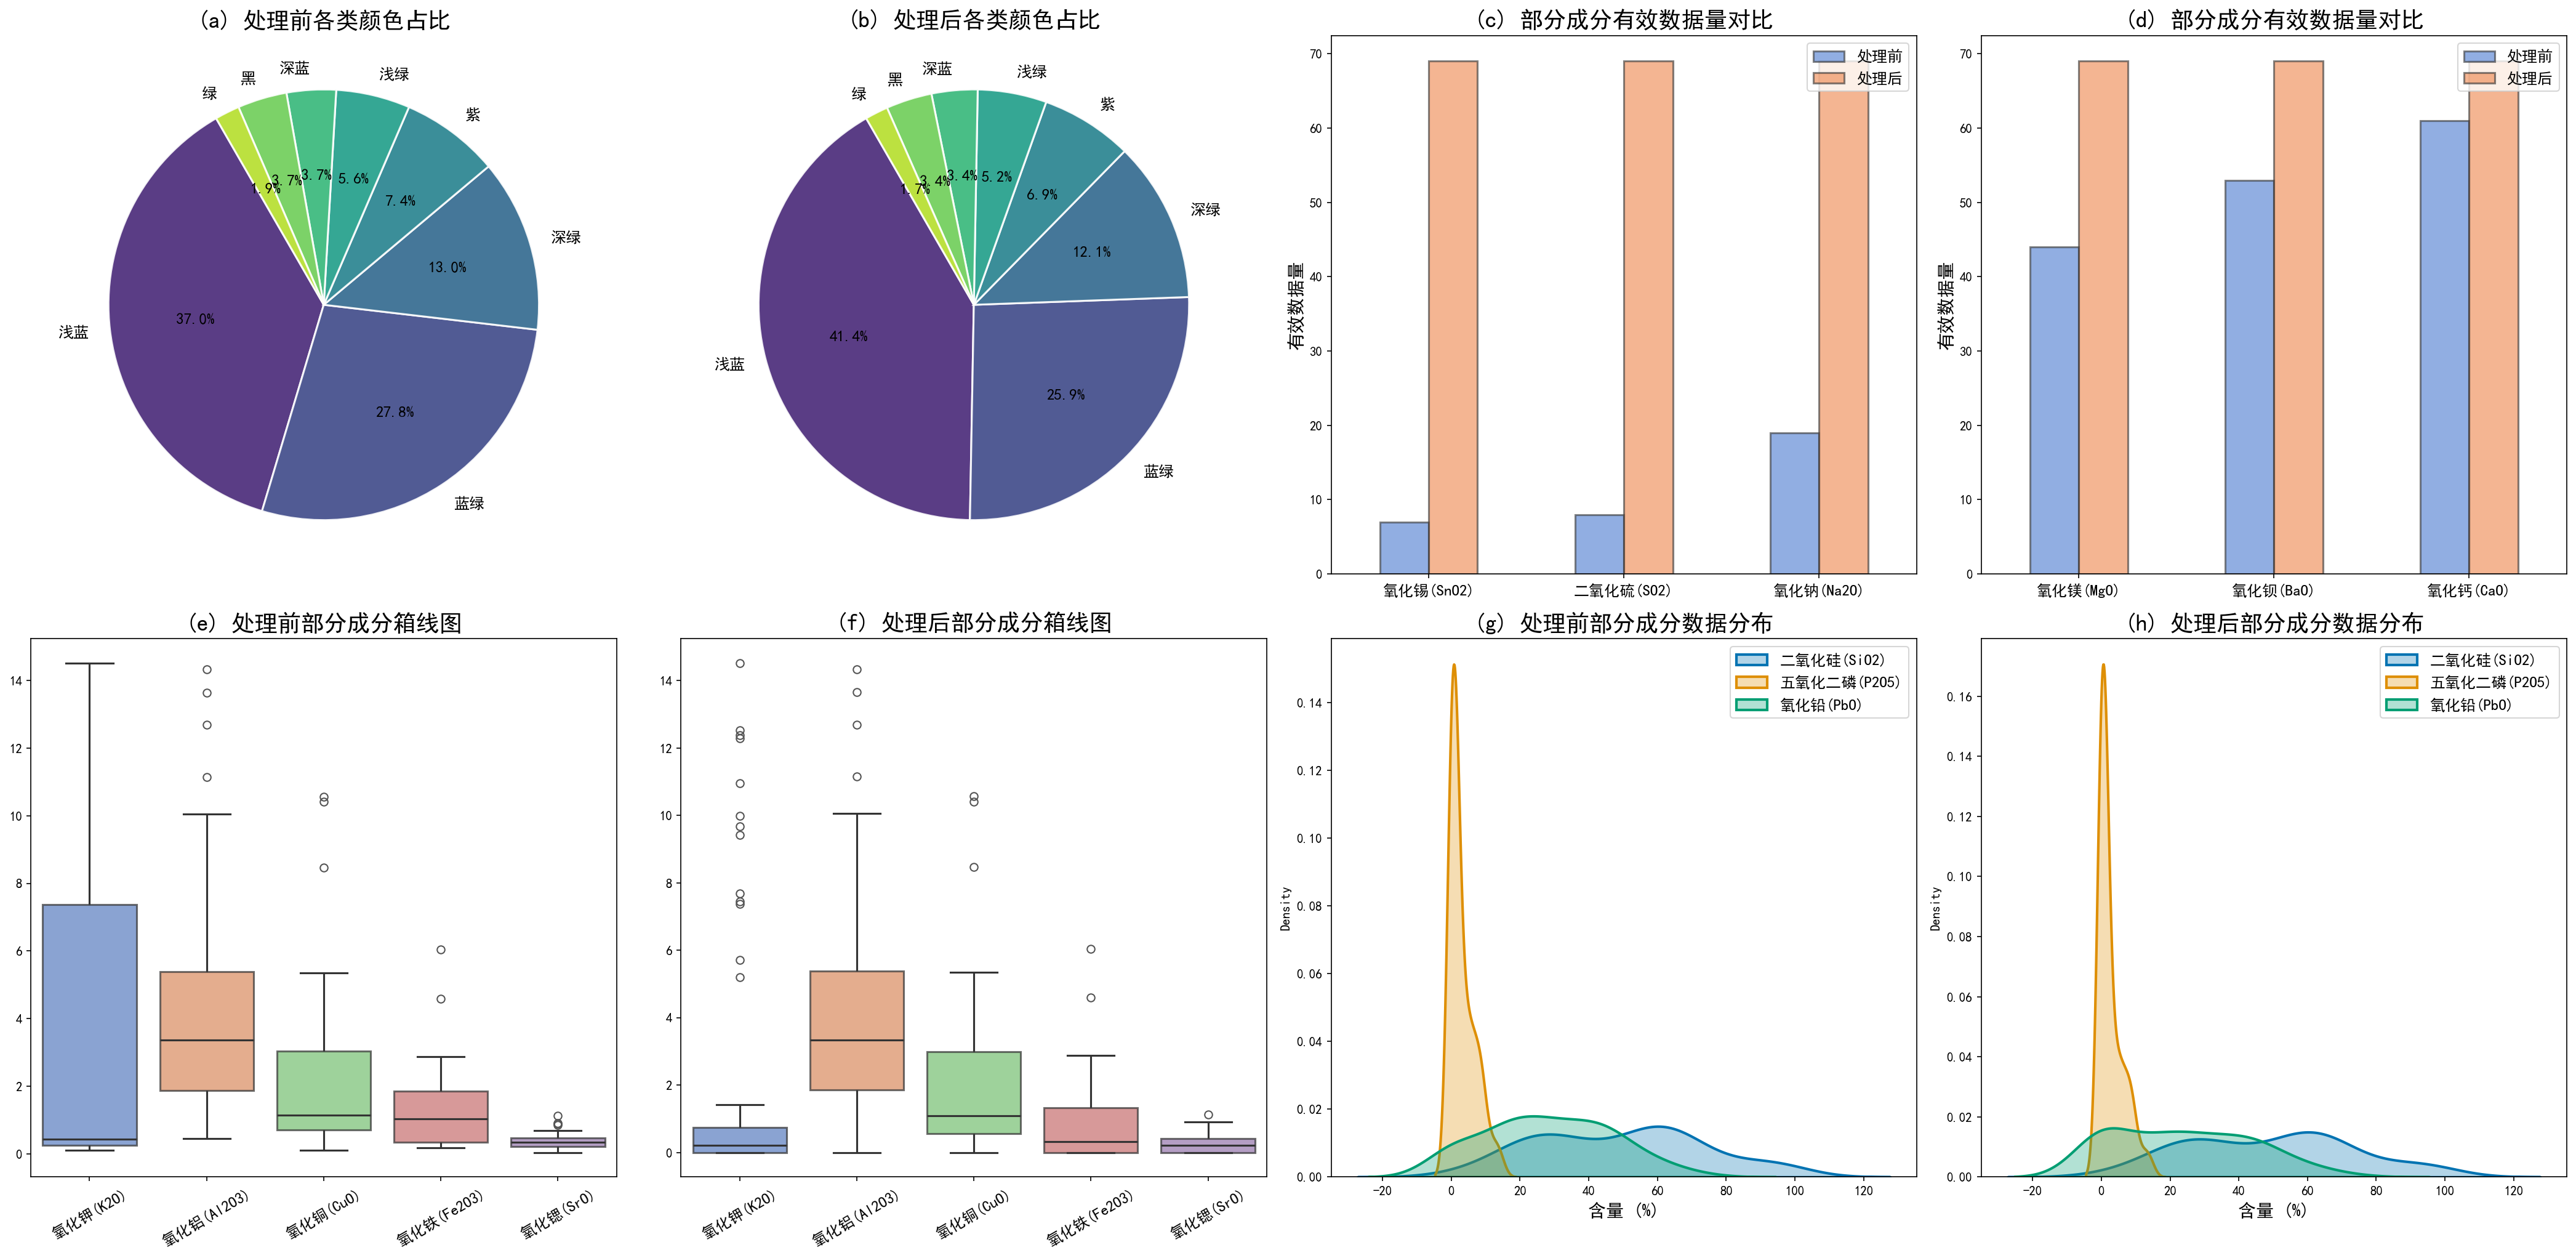

In [10]:
# ==============================================================================
# 阶段三：数据处理效果对比总览图 (终极美化版 III)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- (3.0) 【核心修改】定义最终版、分区的配色与样式方案 ---
# 我记下了您的要求，为不同图表仔细斟酌了配色和样式

# (a,b) 扇形图的新色板：进行“大改”，采用viridis专业色板
pie_color_counts = len(df_info_raw['颜色'].value_counts())
PIE_PALETTE = sns.color_palette("viridis", n_colors=pie_color_counts)

# (c,d,e,f) 统一的边框样式：“同色加粗”
BORDER_COLOR = '#333333' # 使用深灰色作为统一边框色，比纯黑更柔和
BORDER_WIDTH = 1.5

# (c,d) 条形图的填充色
BAR_COLORS = [sns.color_palette("muted")[0], sns.color_palette("muted")[1]]

# (e,f) 箱线图的填充色板
BOX_PALETTE = "muted"


# 假设 df_info_raw, df_info_filled, df_classified_raw, df_classified_filled 已在之前的代码块中成功生成
output_dir = Path('Analysis_Results/')
output_dir.mkdir(parents=True, exist_ok=True)


# --- (3.1) 创建2x4子图网格 ---
fig, axes = plt.subplots(2, 4, figsize=(28, 14))

# --- (a) & (b) 处理前后颜色占比扇形图 ---
# 【颜色修正】应用全新的viridis色板
wedgeprops = {'alpha': 0.9, 'edgecolor': 'white', 'linewidth': 1.5}
ax_a = axes[0, 0]
color_counts_before = df_info_raw['颜色'].value_counts()
ax_a.pie(color_counts_before, labels=color_counts_before.index, autopct='%1.1f%%', 
         startangle=120, colors=PIE_PALETTE, wedgeprops=wedgeprops, textprops={'fontsize': 12})
ax_a.set_title('(a) 处理前各类颜色占比', fontsize=18)

ax_b = axes[0, 1]
color_counts_after = df_info_filled['颜色'].value_counts()
ax_b.pie(color_counts_after, labels=color_counts_after.index, autopct='%1.1f%%', 
         startangle=120, colors=PIE_PALETTE, wedgeprops=wedgeprops, textprops={'fontsize': 12})
ax_b.set_title('(b) 处理后各类颜色占比', fontsize=18)

# --- (c) & (d) 有效数据量前后对比条形图 ---
def plot_valid_data_comparison(ax, components, title, colors):
    before_counts = df_classified_raw[components].notna().sum()
    after_counts = df_classified_filled[components].notna().sum()
    df_plot = pd.DataFrame({'处理前': before_counts, '处理后': after_counts})
    # 【样式修正】应用统一的深色、加粗边框
    df_plot.plot(kind='bar', ax=ax, color=colors, alpha=0.6, 
                 edgecolor=BORDER_COLOR, linewidth=BORDER_WIDTH)
    ax.set_title(title, fontsize=18)
    ax.set_ylabel('有效数据量', fontsize=14)
    ax.tick_params(axis='x', rotation=0, labelsize=12)
    ax.legend(fontsize=12)

plot_valid_data_comparison(axes[0, 2], ['氧化锡(SnO2)', '二氧化硫(SO2)', '氧化钠(Na2O)'], 
                           '(c) 部分成分有效数据量对比', colors=BAR_COLORS)
plot_valid_data_comparison(axes[0, 3], ['氧化镁(MgO)', '氧化钡(BaO)', '氧化钙(CaO)'], 
                           '(d) 部分成分有效数据量对比', colors=BAR_COLORS)

# --- (e) & (f) 箱线图前后对比 ---
components_e = ['氧化钾(K2O)', '氧化铝(Al2O3)', '氧化铜(CuO)', '氧化铁(Fe2O3)', '氧化锶(SrO)']
# 【样式修正】为箱线图的所有线条元素（箱体、须、盖）应用统一的深色、加粗边框
line_props = {'color': BORDER_COLOR, 'linewidth': BORDER_WIDTH}
boxprops = {'edgecolor': BORDER_COLOR, 'linewidth': BORDER_WIDTH, 'alpha': 0.7}

sns.boxplot(data=df_classified_raw[components_e], ax=axes[1, 0], palette=BOX_PALETTE, 
            boxprops=boxprops, whiskerprops=line_props, capprops=line_props, medianprops=line_props)
axes[1, 0].set_title('(e) 处理前部分成分箱线图', fontsize=18)
axes[1, 0].tick_params(axis='x', rotation=30, labelsize=12)

sns.boxplot(data=df_classified_filled[components_e], ax=axes[1, 1], palette=BOX_PALETTE,
            boxprops=boxprops, whiskerprops=line_props, capprops=line_props, medianprops=line_props)
axes[1, 1].set_title('(f) 处理后部分成分箱线图', fontsize=18)
axes[1, 1].tick_params(axis='x', rotation=30, labelsize=12)

# --- (g) & (h) 数据分布的折线填充图 ---
# (遵照您的指示，这部分样式保持不变)
components_g = ['二氧化硅(SiO2)', '五氧化二磷(P2O5)', '氧化铅(PbO)']
# 我记下了您的要求，恢复到第一版的自动配色
for chemical in components_g:
    sns.kdeplot(df_classified_raw[chemical].dropna(), ax=axes[1, 2], 
                label=chemical, fill=True, alpha=0.3, linewidth=2)
    sns.kdeplot(df_classified_filled[chemical], ax=axes[1, 3], 
                label=chemical, fill=True, alpha=0.3, linewidth=2)

axes[1, 2].set_title('(g) 处理前部分成分数据分布', fontsize=18)
axes[1, 2].set_xlabel('含量 (%)', fontsize=14)
axes[1, 2].legend(fontsize=12)

axes[1, 3].set_title('(h) 处理后部分成分数据分布', fontsize=18)
axes[1, 3].set_xlabel('含量 (%)', fontsize=14)
axes[1, 3].legend(fontsize=12)

# --- (3.2) 统一美化与保存 ---

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(output_dir / "图_预处理效果对比总览.png")
plt.show()

--- 成功加载并预处理数据，准备绘制嵌套饼图 ---

✅ 嵌套饼图已成功保存至: Analysis_Results\图_类型与风化嵌套饼图.png


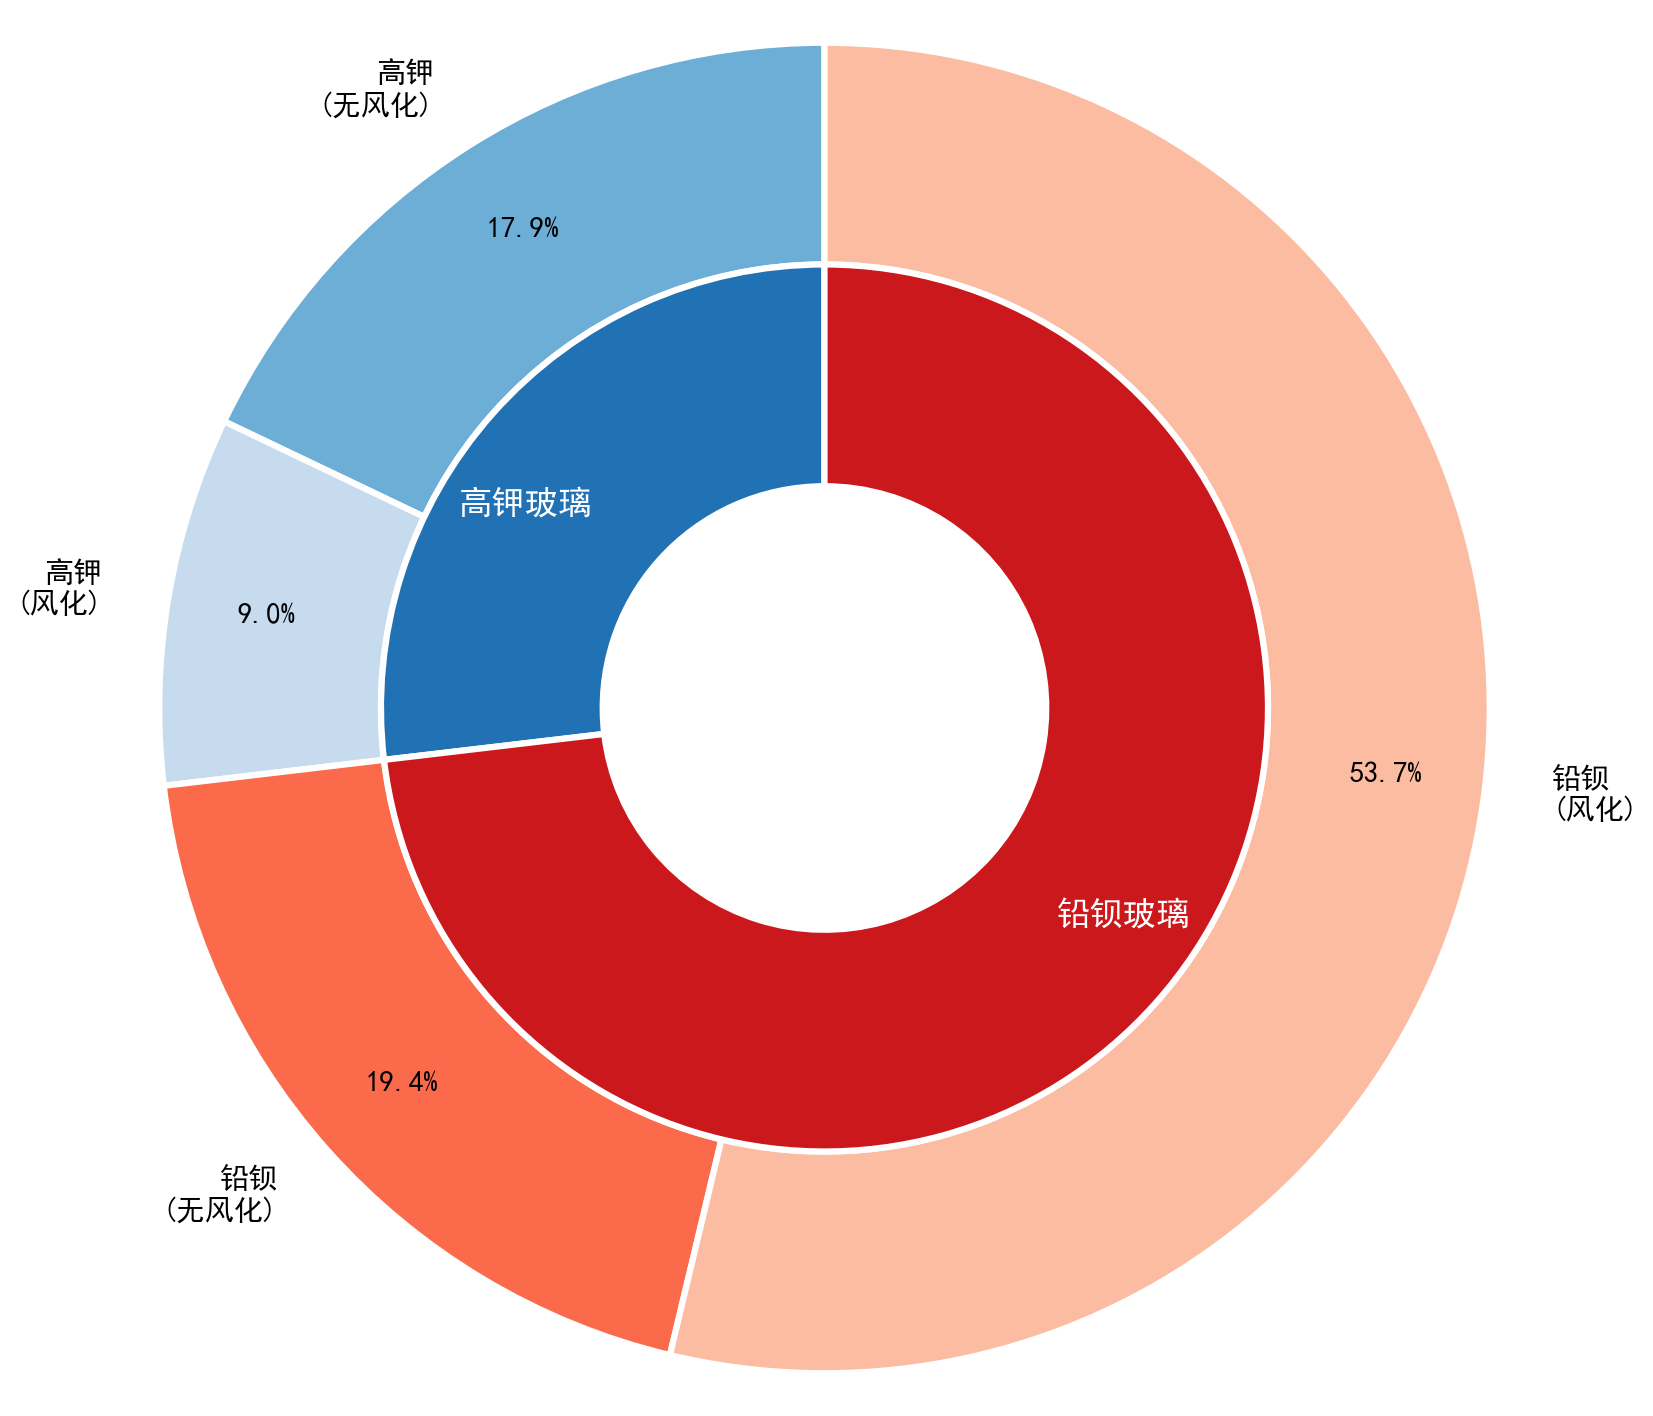

In [11]:
# ==============================================================================
# 嵌套对应关系饼图 (独立完整版)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- (1.1) 全局绘图与环境配置 ---
# 我记下了您的要求，确保所有绘图配置都符合您的学术风格
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

# --- (1.2) 【核心修正】加载原始数据并执行完整预处理 ---
# 此代码块现在从最原始的附件开始，以确保 df_final_cleaned 被成功创建
try:
    # 定义文件路径 (请确保附件在您的工作目录下)
    input_file = Path('../../2022C/附件/附件.xlsx') 
    
    # 加载原始数据
    df_info = pd.read_excel(input_file, sheet_name='表单1')
    df_classified = pd.read_excel(input_file, sheet_name='表单2')
    
    # 执行我们之前确认过的完整预处理流程
    df_classified['文物编号'] = df_classified['文物采样点'].str.extract(r'(\d+)').astype(int)
    df_merged = pd.merge(df_classified, df_info, on='文物编号', how='left')
    chemical_columns = [col for col in df_classified.columns if col not in ['文物采样点', '文物编号']]
    df_merged[chemical_columns] = df_merged[chemical_columns].fillna(0)
    categorical_columns = ['纹饰', '类型', '颜色', '表面风化']
    for col in categorical_columns:
        if col in df_merged.columns:
            df_merged[col] = df_merged[col].fillna('未知')
    df_merged['成分总和'] = df_merged[chemical_columns].sum(axis=1)
    
    # 最终的干净数据框，我们将其命名为 df_final_cleaned
    df_final_cleaned = df_merged[(df_merged['成分总和'] >= 85) & (df_merged['成分总和'] <= 105)].copy()

    print("--- 成功加载并预处理数据，准备绘制嵌套饼图 ---")

except FileNotFoundError:
    print(f"❌ 错误：未在路径 {input_file} 找到原始附件，请检查文件路径。")
    exit()

# --- (1.3) 核心：为嵌套饼图准备数据并排序 ---
# 目标：我们需要计算4个子类别（外环）和2个主类别（内环）的数量
# crosstab是一个非常适合这项任务的工具
data_for_pie = pd.crosstab(df_final_cleaned['类型'], df_final_cleaned['表面风化'])

# 为了保证内外环对齐，我们必须手动指定一个清晰的顺序
# 顺序：高钾-无风化, 高钾-风化, 铅钡-无风化, 铅钡-风化
# 我们使用 .get(key, 0) 来避免当某个类别不存在时出现错误
outer_data = [
    data_for_pie.get('无风化', {}).get('高钾', 0),
    data_for_pie.get('风化', {}).get('高钾', 0),
    data_for_pie.get('无风化', {}).get('铅钡', 0),
    data_for_pie.get('风化', {}).get('铅钡', 0)
]
outer_labels = ['高钾\n(无风化)', '高钾\n(风化)', '铅钡\n(无风化)', '铅钡\n(风化)']

# 内环数据是外环数据的加和
inner_data = [sum(outer_data[0:2]), sum(outer_data[2:4])]
inner_labels = ['高钾玻璃', '铅钡玻璃']

# --- (1.4) 精心设计配色方案 ---
# 我们为两大类分别指定一个主色，外环使用主色的深浅变体
# 我为您仔细斟酌了颜色，使其观感舒适且有区分度
colors_inner = [sns.color_palette("Blues_r", 3)[0], sns.color_palette("Reds_r", 3)[0]]
colors_outer = [sns.color_palette("Blues_r", 3)[1], sns.color_palette("Blues_r", 3)[2],
                sns.color_palette("Reds_r", 3)[1], sns.color_palette("Reds_r", 3)[2]]

# --- (1.5) 绘制嵌套饼图 ---
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制外环
ax.pie(outer_data, 
       radius=1.2, 
       labels=outer_labels,
       colors=colors_outer,
       startangle=90,
       pctdistance=0.85, # 百分比标签的位置
       autopct='%1.1f%%',
       textprops={'fontsize': 14},
       wedgeprops=dict(width=0.4, edgecolor='white', linewidth=3)) # 绘制白色半径线

# 绘制内环
ax.pie(inner_data, 
       radius=0.8,
       labels=inner_labels,
       labeldistance=0.7,
       colors=colors_inner,
       startangle=90,
       textprops={'fontsize': 16, 'weight': 'bold', 'color': 'white'},
       wedgeprops=dict(width=0.4, edgecolor='white', linewidth=3)) # 绘制白色半径线

# 添加中心圆，使其成为Donut图
center_circle = plt.Circle((0,0), 0.4, fc='white')
fig.gca().add_artist(center_circle)



# 保存和显示
output_dir = Path('Analysis_Results/')
output_dir.mkdir(parents=True, exist_ok=True)
save_path = output_dir / "图_类型与风化嵌套饼图.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"\n✅ 嵌套饼图已成功保存至: {save_path}")
plt.show()